In [1]:
%load_ext autoreload
%autoreload 2

### Promblema 
El problema onsiste en predecir la probabilidad de atraso de los vuelos que aterrizan o despegan del aeropuerto de Santiago de Chile (SCL). Para eso les entregamos un dataset usando datos públicos y reales donde cada fila corresponde a un vuelo que aterrizó o despegó de SCL.

1. ¿Cómo se distribuyen los datos? ¿Qué te llama la atención o cuál es tu conclusión sobre esto?

### acercamiento:
para resolver est punto iniciaremos leyendo los datos, viendo la calidad y el tipo de informacion dentro del dataset. haremos la limpieza necesaria y observaremos que mas podemos hacer con la informacion disponible

In [ ]:
# importar librerias
##generacion de path
import latam_airlines.utils.paths as path
## funciones propias
from latam_airlines.utils.latam_utils import check_quality, categorized_days_periods
## manipulacion de datos
import pandas as pd
import numpy as np
## Visualización de los datos
import matplotlib.pyplot as plt
import seaborn as sns

### Lectura y calidad de datos

In [ ]:
# Lectura del archivo dataset_SCL.csv
dataset_SCL = pd.read_csv(path.data_raw_dir('dataset_SCL.csv'), low_memory=False)
dataset_SCL.info()

observamos que:
- En total hay 68206 datos(ojo la fila 0 cuenta como dato)
- Hay columnas que no tiene todas las filas, indicando la existencia de valores faltantes
- Es necesario transformar las columnas de fecha a formato fecha
- Vemos que no consume mucha uso de memoria, por esta razon crearemos una copia para prevenir futuros problemas al cometer algun error.
- No existe nuestr variable target u objetivo, lo que se traduce en featuring data para crear el target

In [ ]:
dataset_SCL_copy = dataset_SCL.copy()
dataset_SCL.sample(10)

### Verificacion de calidad de datos

In [ ]:
check_quality(dataset_SCL)

Verificando la calidad de los datos podemos observar:
- Existen 39 filas con dainformacion NAN que se pueden iliminar.
- las columnas Ori-I,Ori-O,SIGLAORI solo tienen un valor unico asique no aportan informacion, las eliminaremos.
- No hay datos duplicados.
- Exiten un valor unico mas en Des-I que en Des-O, y un valor unico menos en SIGLADES puede ser un error de escritura
- Debemos corregir los errores de escritura para futuras comparaciones.
- Es necesario hacer el cambio de variables string a catgoricas aun.
- Cambiar la columnas fecha a objeto fecha.

In [ ]:
# Eliminamos valores NA
dataset_SCL.dropna(inplace=True)
# Eliminamos columnas que no aportan informacion
dataset_SCL.drop(columns=['Ori-I','Ori-O','SIGLAORI'], inplace=True)

In [ ]:
# Valores unicos y ordenados por columna
dict_DesO = set(dataset_SCL['Des-O'])
dict_DesI = set(dataset_SCL['Des-I'])

# Extraemos las diferencias entre las 2 columnas
only_in_DesO = dict_DesO - dict_DesI
only_in_DesI = dict_DesI - dict_DesO

# Extraemos solo lo qu ecomparten entre las 2 columnas
both = dict_DesO & dict_DesI

# mostramos que hay de diferente
print(f"Elements only in DesO: {only_in_DesO}")
print(f"Elements only in DesI: {only_in_DesI}")
print(f"Len elements both: {len(both)}")

In [ ]:
# Vemos cuantas columnas son para saber si fue un error de typing
dataset_SCL[dataset_SCL['Des-O']==list(only_in_DesO)[0]]


In [ ]:
# Vemos la qie tan diferentes es entre los demas registros
dataset_SCL[dataset_SCL['SIGLADES']=='Cataratas Iguacu']

In [ ]:
# Cambiamos por el valor correspondiente
dataset_SCL.loc[dataset_SCL['Des-I']==list(only_in_DesI)[1],'Des-I'] = 'SBFI'

Como se realizaron modificaciones manuales se crea un archivo con las correciones hechas.

In [ ]:
# Crea dataset .csv
# dataset_SCL.to_csv(path.data_interim_dir('modify_data.csv'), index=False)

# Lee dataset corregido
dataset_SCL = pd.read_csv(path.data_interim_dir('modify_data.csv'), low_memory=False)
dataset_SCL.info()

In [ ]:
# Validación para ver si lo programado es igual a lo operado
dataset_SCL['Vlo_change'] = dataset_SCL.apply(lambda x: '0' if x['Vlo-I']==x['Vlo-O'] else '1', axis=1)
dataset_SCL['Des_change'] = dataset_SCL.apply(lambda x: '0' if x['Des-I']==x['Des-O'] else '1', axis=1)
dataset_SCL['Emp_change'] = dataset_SCL.apply(lambda x:'0' if x['Emp-I']==x['Emp-O'] else '1', axis=1)

In [ ]:
cols = ['Vlo_change','Des_change','Emp_change']

for col in cols:
    print(col)
    print(dataset_SCL[col].value_counts())
    print('='*20)
    print(col+' Porcentaje')
    print(dataset_SCL[col].value_counts(normalize=True)*100)
    print('='*20)

Observamso que:
- El numero de vuelo cambio en la operación en un 6.6% con respecto a todos los vuelos programados.
- La ciudad destino cambio en la operación en un 0.04% con respecto a todos los vuelos programados.
- El codigo de la aerolínea cambio en su ejecución en un 27.37% con respecto a todos los vuelos programados.
- Las nuevas variables Vlo_change y Emp_change tienen la posibilidad de ser empleadas en el proceso de entrenamiento.
- La variables Des_change no serán usadas debido a la baja varianza.

In [ ]:
# Eliminamos columna con baja varianza
dataset_SCL.drop(columns= 'Des_change', inplace=True)

In [ ]:
dataset_SCL.sample(5)

In [ ]:
#Cambiamos el formato a fecha
cols_date = ['Fecha-I','Fecha-O']
for col in cols_date:
    dataset_SCL[col] = pd.to_datetime(dataset_SCL[col], format='%Y-%m-%d %H:%M:%S')

In [ ]:
dataset_SCL.describe(datetime_is_numeric=True)

observamos que:
- La resolucion temporal es de un anio de datos, puntualmente el anio 2017.
- No podemos obtener conclusiones o analizar datos con los dias, meses o anios en formato numero, por que son variables categoricas ordinales,esto al poseer un orden natural.
- Debemos crear o reemplazar las columnas de dia, mes y anio(no tan relevante) con sus respectivo datos categoricos.
- Vemos que las demas variables son string y veremos si es necesario cambiarlas a categorias.

In [ ]:
dataset_SCL.columns

In [ ]:
# creamos variables para ayudarnos a hacer el analisis
days = ['Lunes', 'Martes', 'Miercoles', 'Jueves', 'Viernes', 'Sabado', 'Domingo']
months = ['Ene','Feb','Mar','Abr','May','Jun','Jul','Ago','Sep','Oct','Nov','Dic']
d = dict(zip(np.arange(1, 13),months))
dataset_SCL['MESNOM'] = dataset_SCL['MES'].astype(int).replace(d, regex=True)

#cambiamos las demas variables a formato
cols = ['Vlo-I', 'Des-I', 'Emp-I', 'Vlo-O', 'Des-O','Emp-O', 'DIA', 'MES', 'AÑO', 'DIANOM', 'TIPOVUELO', 'OPERA','SIGLADES', 'Vlo_change','Emp_change']
for col in cols:
    if col == 'DIANOM':
        dataset_SCL[col] = pd.Categorical(dataset_SCL[col],ordered=True, categories=days)
    else:
        dataset_SCL[col] = dataset_SCL[col].astype('category')

dataset_SCL.sort_values('Fecha-I', inplace=True)

In [ ]:
dataset_SCL.head(5)

Con la transformacion de las variables al formato correspondiente iniciamos el analisis de la informacion. Sin embargo, como el objetivo principal es predecir el retraso en los vuelos del aeropuerto es fundamenta crear nuestra variable objetivo o target y otras variables auxiliares, esto nos ayuda a no divagar en los datos u obtener metricas que no estan alineadas a responder nuestro objetivo principal(probabilidad de retraso). Aqui abordaremos el segundo punto del desafio.

### Problema:
2. Genera las columnas adicionales y luego expórtelas en un archivo synthetic_features.csv :
- temporada_alta : 1 si Fecha-I está entre 15-Dic y 3-Mar, o 15-Jul y 31-Jul, o 11-Sep y 30-Sep, 0 si no.
- dif_min : diferencia en minutos entre Fecha-O y Fecha-I.
- atraso_15 : 1 si dif_min > 15, 0 si no.
- periodo_dia : mañana (entre 5:00 y 11:59), tarde (entre 12:00 y 18:59) y noche (entre 19:00 y 4:59), en base a
Fecha-I .

### Acercamiento:
- Usaremos diversas funciones de pandas y numpy para crear estas nuevas columnas
- En términos de velocidad, "np.where" suele ser más rápido que "map" y "apply". Esto se debe a que "np.where" es una función vectorizada que procesa los datos directamente en una matriz numpy, mientras que "map" y "apply" son funciones de pandas que procesan los datos uno por uno. para efecto practicos intentaremos usar cada una.
- Como no hemos hecho un EDA, aprovecharemos la creacion de la variable objetivo para hacer analisis univariados, bivariados y multivariados
- 


### Creacion de la varaible objetivo 'atraso_15'.

En la creacion de la varaible objetivo 'atraso_15'.
- usamos una resta de fechas entre Fecha-O y Fecha-I.
- obtenemos el total en segundos.
- dividir entre 60 seg para obtener los minutos.
- usamos map para obtener 1 si es mayor a 15 min y si no, 0

Validacion y analisis de datos
- cual es la distribucion del atraso? que nos indica?
- Que porcentaje de vuelos tienen un atraso mayor a 15 min?
- Cuales aerolineas presentan mayor atraso?
- que dia y mes de la semana tiene mayor atraso?

In [ ]:
# Crear la columna 'dif_min'
dataset_SCL['dif_min'] = (dataset_SCL['Fecha-O'] - dataset_SCL['Fecha-I']).dt.total_seconds() / 60# numero de segundos en un minuto

# Crear la columna 'atraso_15'
dataset_SCL['atraso_15'] =dataset_SCL['dif_min'].map(lambda x: '1' if x>15 else '0')

In [ ]:
# verificamos la existencia de diferencias negativas en los minutos
print(dataset_SCL[dataset_SCL['dif_min']<0].shape)
(dataset_SCL[dataset_SCL['dif_min']<0].shape[0] / dataset_SCL.shape[0])*100


- Verificamos la existencia de diferencias negativas en los minutos, indicando el adelanto del los vuelos.
- En el anio 2017, 17904 vuelos fueron adelantados representando un 26.3% de los vuelos anuales.
- Nuestro principal objetivo es predecir el atraso, entonces podriamos eliminar estos vuelos, pero la decision la tomaremos ams adelante.


In [ ]:
# vuelos atrasados
print(dataset_SCL['atraso_15'].value_counts())
dataset_SCL['atraso_15'].value_counts(normalize = True)*100

In [ ]:
sns.catplot(
    data= dataset_SCL,
    x='atraso_15',
    kind='count',
)
plt.xlabel('Atraso mayor a 15 min')
plt.ylabel('Numero de Vuelos')
plt.title('conteo de vuelos atrasados en el 2017')
plt.show()

- Podemos observar que 12606 vuelos correspondiendo al 18.5% del 2017 presentaron retraso un retraso de minimo 15 minutos.

In [ ]:
# porcentaje de dias con retraso
dataset_SCL.loc[dataset_SCL['atraso_15']=='1','Fecha-I'].dt.date.nunique()/dataset_SCL['Fecha-I'].dt.date.nunique()*100

Vemos que todos los dias se presento al menos un atraso de 15 minutos

Creamos una tabla de contingencia la cual nos entrega el numero de vuelos con atraso o no para cada Aerolinea, esto con  el fin de ver si hay aerolineas que tienden a presentar atraso o no.

In [ ]:
# Crear tabla de contingencia
top_opera_atraso = pd.crosstab(dataset_SCL['OPERA'], dataset_SCL['atraso_15']).reset_index()

# Calcualo del total de vuelos por operador(Aerolinea)
top_opera_atraso['total'] = top_opera_atraso['0'] + top_opera_atraso['1']
top_opera_atraso['Porcentaje_anual'] =  top_opera_atraso['total'] / top_opera_atraso['total'].sum() *100

# Porcentaje de atraso o no por Aerolinea 
top_opera_atraso['Porcentaje_0'] = top_opera_atraso['0'] / top_opera_atraso['total']*100
top_opera_atraso['Porcentaje_1'] = top_opera_atraso['1'] / top_opera_atraso['total']*100

# top 10 de operador con tasa de atraso mayor a 15 min en la operacion anual
top_opera_atraso.sort_values('1', ascending=False).head(10)

- Obtenemos el top 10 de los operdores que presentan atrasos superiores a 15 minutos, sin embargo esta medida debe ser contrastada con la cantidad de vuelos anuales y tambien por operador

In [ ]:
# top 10 de operador con tasa de atraso mayor a 15 min en su operacion
top_opera_atraso.sort_values(['Porcentaje_1','Porcentaje_anual'],ascending=False).head(10)

Continuamos con el analisis por operador, cambio en nuemero de vuelo, cambio en el codigo de la aerolinea en funcion del atraso

In [ ]:
cols = ['OPERA', 'Vlo_change', 'Emp_change', 'atraso_15']

dataset_SCL_melt= dataset_SCL[cols].melt(id_vars='atraso_15', var_name='cols')
g = sns.displot(
    data=dataset_SCL_melt,
    x='value',
    col='cols',
    hue='atraso_15',
    multiple='fill',
    stat='proportion',
    col_wrap=3,
    facet_kws={'sharey': False, 'sharex': False}
)

for ax in g.axes:
    plt.setp(ax.get_xticklabels(), rotation=90)
    ax.axhline(y=0.5, color='red', linestyle='--')

Analisis por tipo de vuelo, mes del anio y dia de la semana en funcion del atraso

In [ ]:
cols = ['TIPOVUELO', 'MESNOM', 'DIANOM','atraso_15']

dataset_SCL_melt= dataset_SCL[cols].melt(id_vars='atraso_15', var_name='cols')
g = sns.displot(
    data=dataset_SCL_melt,
    x='value',
    col='cols',
    hue='atraso_15',
    multiple='fill',
    stat='proportion',
    col_wrap=3,
    facet_kws={'sharey': False, 'sharex': False}
)

for ax in g.axes:
    plt.setp(ax.get_xticklabels(), rotation=90)
    ax.axhline(y=0.5, color='red', linestyle='--')

Con esta tabla observamos:
- El Grupo Latam tiene una tasa del 60% en vuelos con atraso mayores a 15 min para el 2017 en la operacion total de vuelos, seguido por Sky Airlines con un 21% y Latin American Wings con 2.5%
- El Grupo Latam tiene una tasa de atraso del 18% dentro de su operacion en el aeropuerto SCL, Plus Ultra Lineas Aereas con tasa de operacion 61% esta en el primer puesto,  seguido por Qantas Airways con 58%
- Se observa que los vuelo que presentan cambio en su numero de vuelo tiene mas vuelos atrasados
- No hay una diferencia clara entre los vuelos que cambia de Código aerolínea y el atraso
- Los vuelos internacionales son los que mayor tasa de atraso presentan
- Los meses de Julio, Octubre y Diciembre son los meses con mayor tasa de atraso
- Los Lunes, Jueves y Viernes son los dias con mayor tasa de atraso

### Creacion de nueva columna Temporada alta
En general, "loc" es más adecuado para seleccionar y manipular filas y columnas específicas en un DataFrame, mientras que "np.where" es más adecuado para aplicar operaciones matemáticas y lógicas complejas a los datos.

En la creacion de la nueva feature 'temporada_alta' usamos una mascara con las condicionales necesarias y nos aprovechamos del conocimiento previo de solo tener un anio(2017).
- Como solo tenemos un anio no es necesario hacer una automatizacion de selecion de fechas o algo por el estilo.
- Como nuestra fecha tiene el formato fechas y hora debemos ser precavidos, porque al momento de elegir una fecha menor o igual(<=) el escogera hata las 00 horas de la fecha indicada, asi que debemos agregar un dia mas para seleccione todos los registro de mi fecha limite que va hasta las 23:59 horas, ejemplo: la fecha 3-Mar, debemos colocar en la condicion la fecha 4-Mar, para seleccionar todo el dia 3-mar.
- En la condicion de 1 si Fecha-I está entre 15-Dic y 3-Mar y cambiamos un poco la condicion de 15-Dic o 3-Mar, para que pueda seleccionar el rango de fechas solicitado, esto no afecta el resultado para este caso particular

Validacion y analisis de datos
- cual es la distribucion de la temporada? que nos indica?
- Que porcentaje de vuelos estan en temporada alta?

In [ ]:
# creacion de mascara
temporada_alta = ((dataset_SCL['Fecha-I']>='2017-12-15') | (dataset_SCL['Fecha-I']<='2017-03-04')) | \
    ((dataset_SCL['Fecha-I']>='2017-07-15') & (dataset_SCL['Fecha-I']<='2017-08-01')) | \
        ((dataset_SCL['Fecha-I']>='2017-09-11') & (dataset_SCL['Fecha-I']<='2017-10-01'))

# podemos hacerlo con .loc tambien 
dataset_SCL['temporada_alta'] = np.where(temporada_alta, '1', '0')

# Validación en porcentaje
dataset_SCL['temporada_alta'].value_counts(normalize = True)*100

In [ ]:
# porcentaje de dias en temporada alta
dataset_SCL.loc[dataset_SCL['temporada_alta']=='1','Fecha-I'].dt.date.nunique()/dataset_SCL['Fecha-I'].dt.date.nunique()*100

### Crear la columna 'periodo_dia'

In [ ]:
# Crear la columna 'periodo_dia'
dataset_SCL['periodo_dia'] = dataset_SCL.apply(categorized_days_periods, axis=1)
dataset_SCL['periodo_dia'].value_counts(normalize = True)*100

In [ ]:
# Validación la correcta creacion de periodo
dataset_SCL['HORA']=dataset_SCL['Fecha-I'].dt.hour
dataset_SCL.groupby(by=['periodo_dia','HORA']).size()

In [ ]:
cols = ['periodo_dia','temporada_alta', 'atraso_15']

dataset_SCL_melt= dataset_SCL[cols].melt(id_vars='atraso_15', var_name='cols')
g = sns.displot(
    data=dataset_SCL_melt,
    x='value',
    col='cols',
    hue='atraso_15',
    multiple='fill',
    stat='proportion',
    col_wrap=2,
    facet_kws={'sharey': False, 'sharex': False}
)

for ax in g.axes:
    plt.setp(ax.get_xticklabels(), rotation=90)
    ax.axhline(y=0.5, color='red', linestyle='--')

Observamos que: 
- Un 33% de los vuelos del anio 2017 fueron hechos en temporada alta
- El 31% o 116 dias del anio estan en temporada alta
- Hay poca diferencia entre el atraso y la temporada alta
- La noche presenta la menor tasa de vuelos del dia con 25.5%
- La mañana y tarde tiene tasas simimilares 37%
- La noche y la tarde tienen tasas similares respecto al atraso de vuelos
- La manana presenta una tasa menor que el resto del dia

Creamos una tabla de contingencia la cual nos entrega el numero de vuelos con atraso o no para cada ciudad de destino, esto con  el fin de ver si hay ciudades que tienden a presentar retraso o no.

In [ ]:
# Crear una tabla de contingencia
top_destinos = pd.crosstab(dataset_SCL['Des-I'], dataset_SCL['atraso_15']).reset_index()

# Calcualo del total de vuelos por destino
top_destinos['total'] = top_destinos['0'] + top_destinos['1']
top_destinos['Porcentaje_anual'] =  top_destinos['total'] / top_destinos['total'].sum() *100

# Porcentaje de atraso o no por destino 
top_destinos['Porcentaje_0'] = top_destinos['0'] / top_destinos['total']*100
top_destinos['Porcentaje_1'] = top_destinos['1'] / top_destinos['total']*100
# tabla_contingencia.describe()

# top 10 de destinos con atraso mayor a 15 min en el anio
top_destinos.sort_values('1', ascending=False).head(10)

In [ ]:
# top 10 de destinos con atraso mayor a 15 min en el anio SLCB
top_destinos.sort_values('total').head(10)

In [ ]:
# top 10 de destinos de tasa anual
top_destinos.sort_values(['Porcentaje_anual'],ascending=False).head(10)

In [ ]:
# top 10 de destinos con minimo de 12 vuelos al anio
top_destinos[top_destinos['total']>=12].sort_values(['Porcentaje_1'],ascending=False).head(10)

In [ ]:
# filtrar por cantidad de vuelos al anio
DesI_filter = top_destinos[top_destinos['total']<=12]['Des-I'].unique()
dataset_SCL = dataset_SCL[~dataset_SCL['Des-I'].isin(DesI_filter)]

Observamos que:
- Lima, Sao paulo y Antofagasta son las ciudades que mas cantidad de vuelos presentan atrasos y una tasa de retraso de 23%, 25% y 15% respectivamente.
- Lima, Sao paulo y Antofagasta tienen una tasa de vuelos anual de 7.7%, 5.2% y 8.4% respectivamente.
- Antofagasta, Lima y Calama son las ciudades que mas cantidad de vuelos presentan, Calama representa el 7.5% de tasa anual.
- ciudades con un pocos vuelos al anio presentaron un retraso superior a 15 min, lo que agregaria ruido a las metricas, por eso selecionamos que tenga como minimo 12 vuelos al anio
- Sydney, Melbourne y Rosario son los destinos con mayor tasa de atraso con 58%, 55% y 40% respectivamente

In [ ]:
cols = ['Des-I', 'atraso_15']
dataset_SCL_melt= dataset_SCL[cols].melt(id_vars='atraso_15', var_name='cols')

g = sns.displot(
    data=dataset_SCL_melt,
    x='value',
    col='cols',
    hue='atraso_15',
    multiple='fill',
    stat='proportion',
    col_wrap=1,
    height=5, 
    aspect=2,
    facet_kws={'sharey': False, 'sharex': False}
)
# plt.xlabel('Destinos')
# plt.ylabel('Proporcion')
# plt.title('Propocion de vuelos atrasados por destino')
# plt.setp(ax.get_xticklabels(), rotation=90)

for ax in g.axes:
    # plt.figure(figsize = (15, 8))
    plt.xlabel('Destinos')
    plt.ylabel('Proporcion')
    plt.title('Propocion de vuelos atrasados por destino')
    plt.setp(ax.get_xticklabels(), rotation=90)
    ax.axhline(y=0.5, color='red', linestyle='--')

In [ ]:
# Exportar las columnas adicionales a un archivo .csv
dataset_SCL.to_csv(path.data_processed_dir('synthetic_features.csv'), index=False)

3. ¿Cómo se compone la tasa de atraso por destino, aerolínea, mes del año, día de la semana, temporada, tipo de vuelo?
¿Qué variables esperarías que más influyeran en predecir atrasos?

¿Cómo se compone la tasa de atraso por destino, aerolínea, mes del año, día de la semana, temporada, tipo de vuelo?
- Lima, Sao paulo y Antofagasta son las ciudades que mas cantidad de vuelos presentan atrasos y una tasa de retraso de 23%, 25% y 15% respectivamente.
-  El Grupo Latam tiene una tasa del 60% en vuelos con atraso mayores a 15 min para el 2017 en la operacion total de vuelos, seguido por Sky Airlines con un 21% y Latin American Wings con 2.5%
- El Grupo Latam tiene una tasa de atraso del 18% dentro de su operacion en el aeropuerto SCL, Plus Ultra Lineas Aereas con tasa de operacion 61% esta en el primer puesto,  seguido por Qantas Airways con 58%
- Los meses de Julio, Octubre y Diciembre son los meses con mayor tasa de atraso
- Los Lunes, Jueves y Viernes son los dias con mayor tasa de atraso
- Un 33% de los vuelos del anio 2017 fueron hechos en temporada alta
- El 31% o 116 dias del anio estan en temporada alta
- Hay poca diferencia entre el atraso y la temporada alta
- Los vuelos internacionales son los que mayor tasa de atraso presentan

¿Qué variables esperarías que más influyeran en predecir atrasos?

Las variables que espero que mas influyan al predecir un atraso son:
- Destino
- Aerolínea
- Mes del año
- Día de la semana
- Temporada
- Tipo de vuelo
- Cambio de número de vuelo
- Cambio de código aerolínea

Esto lo podremos verificar con un test de chi-cuadrado

In [ ]:
dataset_SCL.sample(5)

In [ ]:
# Creamos una variable minuto
dataset_SCL['MIN']=dataset_SCL['Fecha-I'].dt.minute

In [ ]:
dataset_SCL.head(5)

In [ ]:
dataset_SCL.columns

No usaremos las siguiente columnas:
- Fecha-I = creamos las columnas 'DIA', 'MES', 'AÑO',  'HORA', 'MIN' que le ayudaran al modelo a interpertar mejor el formato fecha.
- Vlo-I, Vlo-O = creamos las columna 'Vlo_change' que le ayudaran al modelo a interpertar mejor estas dos columnas.
- Emp-I, Emp-O = creamos las columna 'Emp_change' que le ayudaran al modelo a interpertar mejor estas dos columnas.
- Des-O = vimos que no representa gran variabilidad por eso se elimina por que no ayudaria al modelo a determinar un atraso.
- dif_min = por que esta correlacionada con con nuestr variable target 'atraso_15' ya se formo apartir de ella. 
- Fecha-O = hace parte de la creacion del targe. 
- SIGLADES = por que tenemos la columna 'Des-I' que resume mejor esta columna.

In [ ]:
data_train = dataset_SCL[['DIA', 'MES', 'AÑO',  'HORA', 'MIN', 'periodo_dia', 'DIANOM', 'MESNOM','Des-I', 'TIPOVUELO', 'OPERA', 'Vlo_change', 'Emp_change', 'temporada_alta', 'atraso_15']]
data_train.head(5)

In [ ]:
# Exportar las columnas adicionales a un archivo .csv
data_train.to_csv(path.data_processed_dir('data_train.csv'), index=False)

# Creacion de Data aumentation

In [ ]:
# Importar las librerías necesarias
import latam_airlines.utils.paths as path
from latam_airlines.utils.latam_utils import check_quality

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [ ]:
# leemos el dataset de training
data_train = pd.read_csv(path.data_processed_dir('data_train.csv'))
data_train.sample(5)

Para saber cuales serian las variables que mas pueden aporatar al modelo podemos hacer un test estadistico, Como la variable objetivo (y) es categórica, en lugar de utilizar un ANOVA para hacer una comparación de medias de las variables independientes, se puede utilizar un test estadístico para comparar la distribución de las variables independientes para cada categoría de la variable objetivo. Una opción popular es el test chi-cuadrado, que se puede calcular utilizando la función scipy.stats.chi2_contingency. Este test permite determinar si existe una asociación significativa entre la variable objetivo y cada una de las variables independientes.

In [ ]:
cols = data_train.drop('atraso_15', axis=1).columns
for col in cols:
    if col in ['DIA','MES','AÑO', 'HORA','MIN']:
        data_train[col] = data_train[col].astype(int).astype(str)
    else:
        data_train[col] = data_train[col].astype(str)

In [ ]:
from scipy.stats import chi2_contingency

p_value = []
cols = data_train.drop('atraso_15', axis=1).columns
for col in cols:
    # Crea las tablas de contingencia para cada variable independiente
    contingency_table_1 = pd.crosstab(data_train['atraso_15'], data_train[col])

    # Realiza la prueba de chi-cuadrado para cada tabla de contingencia
    chi2, p_value_1, dof, expected_values_1 = chi2_contingency(contingency_table_1)
    if p_value_1< 0.05:
        p_value.append({col:p_value_1})
        # Imprime los resultados
        print(f'P-value variable {col}: {p_value_1}')

Como resultados observamos que las variables escogidas son eimportante para poder predecir el atraso y nos aportan informacion relevante, a excepcion del anio, que no supero el test

In [ ]:
data_train.drop(columns='AÑO', inplace=True)
data_train.head(5)

In [ ]:
data_train.info()

In [ ]:
sns.catplot(
    data= data_train,
    x='atraso_15',
    kind='count',
)
plt.xlabel('Atraso mayor a 15 min')
plt.ylabel('Numero de Vuelos')
plt.title('conteo de vuelos atrasados en el 2017')
plt.show()

In [ ]:
col_order = ['DIA', 'MES', 'HORA', 'MIN','Vlo_change', 'Emp_change','temporada_alta','periodo_dia','DIANOM', 'MESNOM','Des-I', 'TIPOVUELO', 'OPERA','atraso_15']
data_train = data_train[col_order]

In [ ]:
# Obtiene las características y la variable objetivo
X = data_train.drop("atraso_15", axis=1)
y = data_train["atraso_15"]

# Crear una pipeline que incluya el ColumnTransformer
# Crear un objeto ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler( with_mean=False), ['DIA', 'MES', 'HORA', 'MIN','Vlo_change', 'Emp_change','temporada_alta']),
        ('cat-nominal', OneHotEncoder(), ['periodo_dia','DIANOM', 'MESNOM','Des-I', 'TIPOVUELO', 'OPERA'])
    ],
    )

#transformar datos
X_transform = preprocessor.fit_transform(X)

# Aplica SMOTE para generar datos sintéticos
smote = SMOTE(sampling_strategy='minority',random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_transform, y)

# Inversión de la transformación de escalamiento
scaler = preprocessor.named_transformers_['num']
X_scaled = scaler.inverse_transform(X_resampled[:, :7])

# Inversión de la transformación One-hot
onehot = preprocessor.named_transformers_['cat-nominal']
X_onehot = X_resampled[:, 7:]
X_original = onehot.inverse_transform(X_onehot)

# Concatena los valores originales y convierte el resultado en un DataFrame
X_recovered = np.concatenate([X_scaled.toarray().astype(int), X_original], axis=1)

In [ ]:
data_train_balanced = pd.DataFrame(X_recovered, columns=X.columns)
data_train_balanced["atraso_15"] = y_resampled

In [ ]:
sns.catplot(
    data= data_train_balanced,
    x='atraso_15',
    kind='count',
)
plt.xlabel('Atraso mayor a 15 min')
plt.ylabel('Numero de Vuelos')
plt.title('conteo de vuelos atrasados en el 2017')
plt.show()

In [ ]:
check_quality(data_train_balanced)

In [ ]:
data_train_balanced.drop_duplicates(inplace=True)

In [ ]:
# Guarda el dataset balanceado en un archivo
data_train_balanced.to_csv(path.data_processed_dir('data_train_balanced.csv'), index=False)

# creacion del modelo de clasificacion

4. Entrena uno o varios modelos (usando el/los algoritmo(s) que prefieras) para estimar la probabilidad de atraso de un vuelo.
Siéntete libre de generar variables adicionales y/o complementar con variables externas.

5. Evalúa tu modelo. ¿Qué performance tiene? ¿Qué métricas usaste para evaluar esa performance y por qué? ¿Por qué
elegiste ese algoritmo en particular? ¿Qué variables son las que más influyen en la predicción? ¿Cómo podrías mejorar la
performance?

### Métricas para evaluación de modelos con datos desbalanceados 

#### Efecto de datos desbalanceados

- El accuracy es engañosa

El rendimiento de los algoritmos de aprendizaje automático se evalúa normalmente mediante el accuracy. Sin embargo, esto no es apropiado cuando los datos están desbalanceados y/o los costos de los diferentes errores varían significativamente, dado que se puede obtener un acurracy bastante alto con sólo predecir la clase mayoritaria sin tomar en cuenta la clase minoritaria, que por lo regular suele ser el objetivo por el cuál se está realizando el modelo de clasificación.

Por ejemplo, se hace uso de un conjunto de datos que contiene transacciones hechas con tarjetas de credito en Europa en septiembre de 2013. Se está interesado en predecir si una persona incumplirá con el pago de su tarjeta. Se observa que de las 284807 transacciones registradas, sólo 492 corresponden a personas que incumplieron con el pago de su tarjeta (0.2 %), por lo que un modelo que clasifique todas las observaciones como no fraudulentas obtendría un accuracy igual a 99.8 %. Esta precisión sería alta simplemente porque la mayoría de las transacciones no son fraudulentas y no porque el modelo sea bueno.

- AUC ROC es demasiado optimista

La curva Receiver Operating Characteristics (ROC) y el área bajo la curva ROC (AUROC) se han convertido en la métrica más común para evaluar un modelo de clasificación.

El área bajo la curva (AUROC) es una métrica de rendimiento que se puede utilizar para evaluar modelos de clasificación. AUROC permite medir si un modelo puede clasificar correctamente los ejemplos. AUROC es una métrica de rendimiento para la “discriminación”: permite medir la capacidad del modelo para discriminar entre casos (ejemplos positivos) y no casos (ejemplos negativos). Un AUROC de 0.8 significa que el modelo tiene una buena capacidad de discriminación: 80 % de las ocasiones, el modelo asignará correctamente un riesgo absoluto más alto a un paciente seleccionado al azar con un evento que a un paciente seleccionado al azar sin un evento.

El peor AUROC es 0.5 y el mejor AUROC es 1.0.

Sin embargo, cuando la clase negativa es más frecuente pero hay un valor bajo en las predicciones negativas verdaderas esta metrica no presenta buenos resultados.

Por ejemplo, considere el caso de un conjunto de datos que tiene 10 positivos y 100000 negativos. Se dispone de 2 modelos:

Modelo A: predice 900 positivos, de los cuales 9 son verdaderos positivos Modelo B: predice 90 positivos, de los cuales 9 son verdaderos positivos

Obviamente, el Modelo B tiene un mejor rendimiento. Aunque ambos predicen el mismo número de positivos, el Modelo B no genera tantos falsos positivos. En otras palabras, el Modelo B es más “preciso”. Sin embargo, considere el análisis ROC de los dos modelos, que mide la tasa de verdaderos positivos (TPR) contra la tasa de falsos positivos
(FPR):

- Modelo A: TPR = 9/10 = 0.9 y FPR = (900–9) / 100,000 = 0.00891 Modelo B: TPR = 9/10 = 0.9 y FPR = (90–9) / 100,000 = 0.00081

Como era de esperar, TPR es exactamente el mismo entre ambos modelos. Por otro lado, dado que el número de negativos domina en gran medida al de positivos, la diferencia de FPR entre ambos modelos (0.00891-0.00081 = 0.0081) se pierde en el sentido de que se puede redondear a casi 0.

En otras palabras, un gran cambio en el número de falsos positivos resultó en un pequeño cambio en el FPR y, por lo tanto, la curva ROC no puede reflejar el desempeño superior del Modelo B en el contexto de que los verdaderos negativos no son relevantes para el problema.

- Precision-Recall

En contraste, la curva Precision-Recall (PR) está diseñada específicamente para la detección de eventos raros y es la métrica que debe usarse cuando la clase positiva es de más interés que la negativa.

Debido a que la precisión y la recall no consideran verdaderos negativos, la curva PR no se ve afectada por el desequilibrio de datos. Volviendo al ejemplo anterior:
Modelo A: Recall = TPR = 0.9 y Precision = 9/900 = 0.01 Modelo B: Recall = TPR = 0.9 y Precision = 9/90 = 0.1

Claramente, el análisis de PR es más informativo en comparación con el análisis de la curva ROC.

### Entrenamiento o Training del modelo de clasifiacion binario
Como sabemos nuestro dataset esta desbalanceado por este motivo recorreremos 3 caminos para seleccionar el mejor modelo
- entrenamiento con datos desbalanceados, posblemente tengamos un accuracy alto pero el PR de label 1(atraso) sean bajas
- entrenamiento con datos balanceados usando sub-muestreo, osea, igualar los labels eliminando datos de la clase con mas informacion, posiblemente tengamos un accuracy aceptable o bueno y un PR similar entre los labels.
- entrenamiento con datos balanceados usando sobre-muestreo, osea, igualar los labels aumentando los datos de la clase con menos informacion, posiblemente tengamos un accuracy aceptable o bueno y un PR similar entre los labels.

In [19]:
# Importar las librerías necesarias
import latam_airlines.utils.paths as path
from latam_airlines.utils.latam_utils import modelPipeline, get_model_performance_test_set, save_simple_metrics_report, update_model

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import classification_report, f1_score,precision_score,recall_score,accuracy_score, confusion_matrix

rs = {'random_state': 42}

## Camino 1 - sin balancear el dataset

In [ ]:
# leemos el dataset de training
data_train = pd.read_csv(path.data_processed_dir('data_train.csv'))
data_train.drop(columns='AÑO', inplace=True)

In [ ]:
sns.catplot(
    data= data_train,
    x='atraso_15',
    kind='count',
)
plt.xlabel('Atraso mayor a 15 min')
plt.ylabel('Numero de Vuelos')
plt.title('conteo de vuelos atrasados en el 2017')
plt.show()

In [ ]:
# Dividir los datos en variables de entrada y salida
X = data_train.drop('atraso_15', axis=1)
y = data_train['atraso_15']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
# entrenamos y evaluamos diferentes modelos
pipelines, scores_df = modelPipeline(X_train, X_test, y_train, y_test)
scores_df

Esta tabla muestra los resultados de 5 modelos diferentes de ML en un problema de clasificación. Las métricas incluyen F1 Score, Precision, Recall y Accuracy. Estas métricas permiten evaluar la capacidad de los modelos para clasificar correctamente las etiquetas de la clase objetivo. 
- F1 Score es una métrica combinada de Precision y Recall. 
- Precision mide la cantidad de etiquetas positivas correctas en comparación con las etiquetas positivas totales predichas. osea, la capacidad del modelo de clasificar realmente si un vuelo se atraso 
- Recall mide la cantidad de etiquetas positivas correctas en comparación con las etiquetas positivas totales reales. osea, el acierto del modelo para clasificar un vuelo con o sin retraso en la realidad
- Accuracy mide la proporción de etiquetas clasificadas correctamente. Esta metrica puede ser enganosa, hay que ver muy bien como se comporta la matriz de confusion

Para la selelcion del modelo tomaremos el modelo que presente mejore metricas.

In [ ]:
# Crear una pipeline que incluya el ColumnTransformer y el RandomForestClassifier
# Crear un objeto ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler( with_mean=False), ['DIA', 'MES', 'HORA', 'MIN','Vlo_change', 'Emp_change','temporada_alta']),
        ('cat-nominal', OneHotEncoder(), ['periodo_dia','DIANOM', 'MESNOM','Des-I', 'TIPOVUELO', 'OPERA'])
    ],
    )
pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model',XGBClassifier(**rs))
    ]
)

In [ ]:
# realizar validacion cruzada
final_result = cross_validate(pipe, X_train, y_train, return_train_score=True, cv=5)
#observamos la dispersion del score
train_score_std = np.std(final_result['train_score'])
test_score_std = np.std(final_result['test_score'])
print('Dispersion del score en la validacion cruzada')
print(f'Dispersion train score: {train_score_std}')
print(f'Dispersion test score: {test_score_std}')

# Observamos la media del score
train_score_mean = np.mean(final_result['train_score'])
test_score_mean = np.mean(final_result['test_score'])
print('media del score en la validacion cruzada')
print(f'media train score: {train_score_mean}')
print(f'media test score: {test_score_mean}')

# Entrenar modelo
pipe.fit(X_train, y_train)
# Mostrar los resultados

validation_score =pipe.score(X_test, y_test)

y_pred = pipe.predict(X_test)

# Imprimiendo el reporte de clasificación
report = classification_report(y_test, y_pred)
print(report)

Se puede concluir lo siguiente:

- Para la clase 0 (no atraso), el modelo tiene una precision de 0.84, lo que significa que el 84% de los casos clasificados como no atrasados son realmente no atrasados.
- Para la clase 0 (no atraso), el modelo tiene un recall de 0.98, lo que significa que el 98% de los casos reales de no atraso son identificados correctamente por el modelo.
- Para la clase 0 (no atraso), el modelo tiene un f1-score de 0.91, lo que indica un buen desempeño en la clasificación de la clase 0.
- Para la clase 1 (atraso), el modelo tiene una precision de 0.63, lo que significa que solo el 63% de los casos clasificados como atrasados son realmente atrasados.
- Para la clase 1 (atraso), el modelo tiene un recall de 0.17, lo que significa que solo el 17% de los casos reales de atraso son identificados correctamente por el modelo.
- Para la clase 1 (atraso), el modelo tiene un f1-score de 0.27, lo que indica un mal desempeño en la clasificación de la clase 1.
- El accuracy general del modelo es de 0.83, lo que significa que el modelo predice correctamente el 83% de las veces en promedio.

Es importante considerar tanto la precision como el recall para la clase minoritaria (atraso), ya que un modelo con una precision alta pero un recall bajo no será útil si se desea detectar todos los casos de atraso. En este caso, se podría considerar la re-calibración del modelo o la utilización de técnicas de balanceo de datos para mejorar su desempeño en la clasificación de la clase minoritaria.

In [ ]:
get_model_performance_test_set('cm_unbalanced', y_test, y_pred)

In [ ]:
save_simple_metrics_report('report_unbalanced', train_score_mean, test_score_mean, validation_score, report, pipe)

## Camino 2.0 - balanceando el dataset (sub-muestreo)

In [ ]:
# leemos el dataset de training
data_train = pd.read_csv(path.data_processed_dir('data_train.csv'))
data_train.drop(columns='AÑO', inplace=True)

In [ ]:
sns.catplot(
    data= data_train,
    x='atraso_15',
    kind='count',
)
plt.xlabel('Atraso mayor a 15 min')
plt.ylabel('Numero de Vuelos')
plt.title('conteo de vuelos atrasados en el 2017')
plt.show()

In [ ]:
data_train['atraso_15'].value_counts()

In [ ]:
data = pd.concat(
    [data_train[data_train['atraso_15']==0].sample(12596),data_train[data_train['atraso_15']==1]]
)

In [ ]:
sns.catplot(
    data= data,
    x='atraso_15',
    kind='count',
)
plt.xlabel('Atraso mayor a 15 min')
plt.ylabel('Numero de Vuelos')
plt.title('conteo de vuelos atrasados en el 2017')
plt.show()

In [ ]:
# Dividir los datos en variables de entrada y salida
X = data.drop('atraso_15', axis=1)
y = data['atraso_15']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
# entrenamos y evaluamos diferentes modelos
pipelines, scores_df = modelPipeline(X_train, X_test, y_train, y_test)
scores_df

In [ ]:
# Crear una pipeline que incluya el ColumnTransformer y el XGBClassifier
# Crear un objeto ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler( with_mean=False), ['DIA', 'MES', 'HORA', 'MIN','Vlo_change', 'Emp_change','temporada_alta']),
        ('cat-nominal', OneHotEncoder(), ['periodo_dia','DIANOM', 'MESNOM','Des-I', 'TIPOVUELO', 'OPERA'])
    ],
    )
pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model',XGBClassifier(**rs))
    ]
)

# realizar validacion cruzada
final_result = cross_validate(pipe, X_train, y_train, return_train_score=True, cv=5)
#observamos la dispersion del score
train_score_std = np.std(final_result['train_score'])
test_score_std = np.std(final_result['test_score'])
print('Dispersion del score en la validacion cruzada')
print(f'Dispersion train score: {train_score_std}')
print(f'Dispersion test score: {test_score_std}')

# Observamos la media del score
train_score_mean = np.mean(final_result['train_score'])
test_score_mean = np.mean(final_result['test_score'])
print('media del score en la validacion cruzada')
print(f'media train score: {train_score_mean}')
print(f'media test score: {test_score_mean}')

# Entrenar modelo
pipe.fit(X_train, y_train)
# Mostrar los resultados

validation_score =pipe.score(X_test, y_test)

y_pred = pipe.predict(X_test)

# Imprimiendo el reporte de clasificación
report = classification_report(y_test, y_pred)
print(report)

Se puede concluir lo siguiente:

- Para la clase 0 (no atraso), el 67% de los casos clasificados como no atrasados son realmente no atrasados.
- Para la clase 0 (no atraso), el 66% de los casos reales de no atraso son identificados correctamente por el modelo.
- Para la clase 1 (atraso), el 66% de los casos clasificados como atrasados son realmente atrasados.
- Para la clase 1 (atraso), el 67% de los casos reales de atraso son identificados correctamente por el modelo.
- El accuracy general del modelo es de 0.67, lo que significa que el modelo predice correctamente el 67% de las veces en promedio.

En este caso, se podría considerar hacer un over-sampling del modelo para mejorar su desempeño en la clasificación de las clases.

In [ ]:
get_model_performance_test_set('cm_balanced_sub', y_test, y_pred)

In [ ]:
save_simple_metrics_report('report_balanced_sub', train_score_mean, test_score_mean, validation_score, report, pipe)
update_model('model_balanced_sub',pipe)

## Camino 2.1 - balanceando el dataset (sobre-muestreo)

In [ ]:
data_train_balanced = pd.read_csv(path.data_processed_dir('data_train_balanced.csv'))

In [ ]:
sns.catplot(
    data= data_train_balanced,
    x='atraso_15',
    kind='count',
)
plt.xlabel('Atraso mayor a 15 min')
plt.ylabel('Numero de Vuelos')
plt.title('conteo de vuelos atrasados en el 2017')
plt.show()

In [ ]:
# Dividir los datos en variables de entrada y salida
X = data_train_balanced.drop('atraso_15', axis=1)
y = data_train_balanced['atraso_15']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
pipelines, scores_df = modelPipeline(X_train, X_test, y_train, y_test)
scores_df

Como lo mencione anteriormente se escoge el modelo que mejor metricas tienen, aca demebmos tomar en cuenta que el modelo de RandomForestClassifier es algo pesado si lo consideramos para el paso a produccion.

In [ ]:
# Crear una pipeline que incluya el ColumnTransformer y el RandomForestClassifier
# Crear un objeto ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler( with_mean=False), ['DIA', 'MES', 'HORA', 'MIN','Vlo_change', 'Emp_change','temporada_alta']),
        ('cat-nominal', OneHotEncoder(), ['periodo_dia','DIANOM', 'MESNOM','Des-I', 'TIPOVUELO', 'OPERA'])
    ],
    )
pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model',RandomForestClassifier(**rs))
    ]
)

# realizar validacion cruzada
final_result = cross_validate(pipe, X_train, y_train, return_train_score=True, cv=5)
#observamos la dispersion del score
train_score_std = np.std(final_result['train_score'])
test_score_std = np.std(final_result['test_score'])
print('Dispersion del score en la validacion cruzada')
print(f'Dispersion train score: {train_score_std}')
print(f'Dispersion test score: {test_score_std}')

# Observamos la media del score
train_score_mean = np.mean(final_result['train_score'])
test_score_mean = np.mean(final_result['test_score'])
print('media del score en la validacion cruzada')
print(f'media train score: {train_score_mean}')
print(f'media test score: {test_score_mean}')


# Entrenar modelo
pipe.fit(X_train, y_train)

# Mostrar los resultados
validation_score =pipe.score(X_test, y_test)
y_pred = pipe.predict(X_test)

# Imprimiendo el reporte de clasificación
report = classification_report(y_test, y_pred)
print(report)

Se puede concluir lo siguiente:

- Para la clase 0 (no atraso), el 89% de los casos clasificados como no atrasados son realmente no atrasados.
- Para la clase 0 (no atraso), el 86% de los casos reales de no atraso son identificados correctamente por el modelo.
- Para la clase 1 (atraso), el 82% de los casos clasificados como atrasados son realmente atrasados.
- Para la clase 1 (atraso), el 86% de los casos reales de atraso son identificados correctamente por el modelo.
- El accuracy general del modelo es de 0.86, lo que significa que el modelo predice correctamente el 86% de las veces en promedio.

Podriamos hacer tuning de los hiperparametros de RandomForest, pero este resultado es satisfactorio.

Procedemos a guardar nuestro modelo y sus metricas

In [ ]:
get_model_performance_test_set('cm_balanced_over', y_test, y_pred)

In [ ]:
save_simple_metrics_report('report_balanced_over', train_score_mean, test_score_mean, validation_score, report, pipe)
update_model('model_balanced_over',pipe)

### Validaremos con los datos reales usando las mismas metricas

In [20]:
# leemos el dataset de training
data_train = pd.read_csv(path.data_processed_dir('data_train.csv'))
data_train.drop(columns='AÑO', inplace=True)

In [21]:
# Dividir los datos en variables de entrada y salida
X = data_train.drop('atraso_15', axis=1)
y = data_train['atraso_15']

In [22]:
from latam_airlines.utils.latam_utils import get_model

In [23]:
pipe = get_model('model_balanced_sub.pkl')
y_pred = pipe.predict(X)

# Imprimiendo el reporte de clasificación
report = classification_report(y, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.92      0.68      0.78     55550
           1       0.35      0.74      0.47     12596

    accuracy                           0.69     68146
   macro avg       0.63      0.71      0.63     68146
weighted avg       0.81      0.69      0.73     68146



A pesar de que el modelo entrenado con sub-muestreo tiene un desempenio aceptable vemos que la precision a la hora de predecir el retraso de un vuelo no es eficiente

In [24]:
pipe = get_model('model_balanced_over.pkl')
y_pred = pipe.predict(X)

# Imprimiendo el reporte de clasificación
report = classification_report(y, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.98      0.96      0.97     55550
           1       0.82      0.92      0.87     12596

    accuracy                           0.95     68146
   macro avg       0.90      0.94      0.92     68146
weighted avg       0.95      0.95      0.95     68146



### Concluimos
- El modelo entrenado con sobre-muestreo o creacion de datos sinteticos tiene el mejor desempenio
- la precision y el recall estan balanceadas y altas
- un buen PR significa que el modelo tiene una buena precision y exactitud con datos no visto en su entrenamiento, osea es eficiente a la hora de predecir el retraso de un vuelo.

Como se comportaria el modelo solo con datos del operador LATAM?

In [25]:
data_LATAM = data_train[data_train['OPERA']=='Grupo LATAM']

In [26]:
# Dividir los datos en variables de entrada y salida
X = data_LATAM.drop('atraso_15', axis=1)
y = data_LATAM['atraso_15']

In [27]:
pipe = get_model('model_balanced_over.pkl')
y_pred = pipe.predict(X)

# Imprimiendo el reporte de clasificación
report = classification_report(y, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.98      0.95      0.97     33551
           1       0.81      0.91      0.86      7289

    accuracy                           0.95     40840
   macro avg       0.90      0.93      0.91     40840
weighted avg       0.95      0.95      0.95     40840



Se puede concluir lo siguiente  para el operador LATAM:

- El modelo clasifica el 98% de los casos como no atrasados y son realmente no atrasados.
- El modelo clasifica correctamente el 86% de los casos reales de no atraso.
- El modelo clasifica el 82% de los casos clasificados como atrasados y son realmente atrasados.
- El modelo clasifica correctamente el 86% de los casos reales de atraso.
- El accuracy general del modelo es de 0.86, lo que significa que el modelo predice correctamente el 86% de las veces en promedio.

En otras palabras, el modelo hubiese podido alertar el 82% de los atrasos del grupo LATAM en el aeropuerto SCL del 2017.

### Importancia de las Features en el modelo

In [35]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from latam_airlines.utils.latam_utils import get_model
import latam_airlines.utils.paths as path

In [36]:
pipe = get_model('model_balanced_over.pkl')

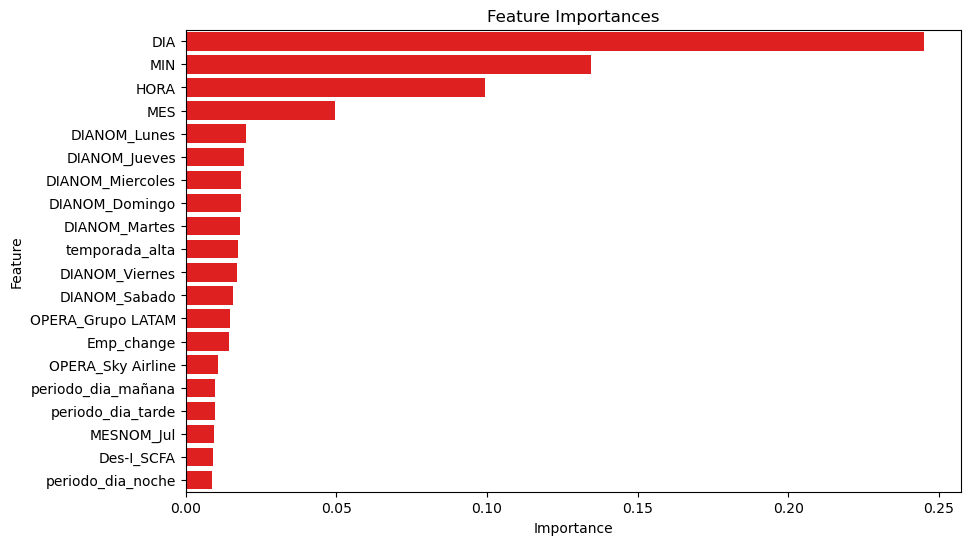

In [49]:
feature_names = pipe['preprocessor'].get_feature_names_out()
feature_names = list(map(lambda x: x.split('__'), feature_names))
feature_names = [elem[1] for elem in feature_names]

# create a DataFrame with feature names and importances
feature_importances = pd.DataFrame(zip(feature_names, pipe['model'].feature_importances_), columns=['feature', 'importance'])

# sort features by importance in descending order
feature_importances = feature_importances.sort_values('importance', ascending=False)

# plot feature importances using a horizontal bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importances.head(20), color='red')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()

In [51]:
feature_importances['importance'].head(5).sum()

0.5482446944420147

el top 5 de las caracteristicas de mayor peso reune el 55% de la explicacion del modelo el top 5 son el dia, minuto, hora, mes y nombre del dia(lunes), esto significando que la fecha hasta el minuto tien un gran peso en el modelo dando luces de que se puede afrontar el modelo como series de tiempo. 